# Mall Customers

## notebook

* Acquire data from mall_customers.customers in mysql database.
* Summarize data (include distributions and descriptive statistics).
* Detect outliers using IQR.
* Split data (train, validate, and test split).
* Encode categorical columns using a one hot encoder (pd.get_dummies).
* Handles missing values.
* Scaling

In [1]:
from env import user, host, password
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

# Acquire data from mall_customers.customers in mysql database.

In [2]:
def get_connection(database, user=user, host=host, password=password):
    '''get URL with user, host, and password from env '''
    
    return f"mysql+pymysql://{user}:{password}@{host}/{database}"

In [3]:
def get_sql_data(database,query):
    ''' 
        Take in a database and query
        check if csv exists for the queried database
        if it does read from the csv
        if it does not create the csv then read from the csv  
    '''
    
    if os.path.isfile(f'{database}_query.csv') == False:   # check for the file
        
        df = pd.read_sql(query, get_connection(database))  # create file 
        
        df.to_csv(f'{database}_query.csv',index = False) # cache file
        
    return pd.read_csv(f'{database}_query.csv') # return contents of file

In [4]:
database = "mall_customers"

query = "select * from customers"

df = get_sql_data(database,query)

# Summarize data (include distributions and descriptive statistics).

In [5]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df.shape

(200, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


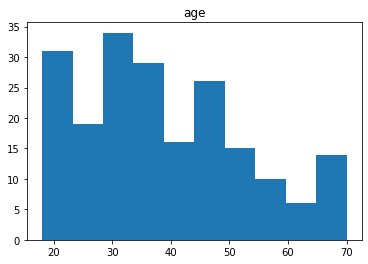

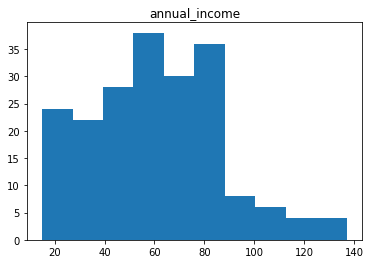

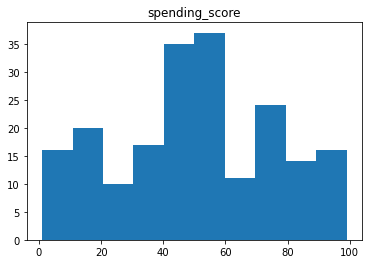

In [9]:
# distribution of the data
num_cols = ['age', 'annual_income', 'spending_score']

for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

Sharp drop off in customer count at 90K income.

<AxesSubplot:title={'center':'spending_score distribution'}>

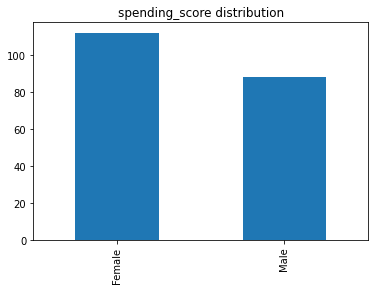

In [10]:
# vis 
df['gender'].value_counts().plot(kind='bar', title = f"{col} distribution")

Slightly more female customers then male customers.

# Detect outliers using IQR.

In [11]:
df.shape

(200, 5)

In [12]:
def detect_outliers(df, k, col_list):
    ''' get upper and lower bound for list of columns in a dataframe 
        if desired return that dataframe with the outliers removed
    '''
    
    odf = pd.DataFrame()
    
    for col in col_list:

        q1, q2, q3 = df[f'{col}'].quantile([.25, .5, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound
        
        # print each col and upper and lower bound for each column
        print(f"{col}: Median = {q2} lower_bound = {lower_bound} upper_bound = {upper_bound}")

        # return dataframe of outliers
        odf = odf.append(df[(df[f'{col}'] < lower_bound) | (df[f'{col}'] > upper_bound)])
            
    return odf

In [14]:
odf = detect_outliers(df, 1.5,['age', 'annual_income', 'spending_score'])

age: Median = 36.0 lower_bound = -1.625 upper_bound = 79.375
annual_income: Median = 61.5 lower_bound = -13.25 upper_bound = 132.75
spending_score: Median = 50.0 lower_bound = -22.625 upper_bound = 130.375


In [15]:
odf

,customer_id,gender,age,annual_income,spending_score
198,199,Male,32,137,18
199,200,Male,30,137,83


# Split data (train, validate, and test split).

In [16]:
def train_validate_test_split(df):
    '''split df into train, validate, test'''
    
    train, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

In [17]:
train, validate, test = train_validate_test_split(df)

In [19]:
print(train.shape, validate.shape, test.shape)

(112, 5) (48, 5) (40, 5)


# Encode categorical columns using a one hot encoder (pd.get_dummies).

In [20]:
def encoding(df, cols, drop_first=True):
    '''
    Take in df and list of columns
    add encoded columns derived from columns in list to the df
    '''
    for col in cols:

        dummies = pd.get_dummies(df[f'{col}'], drop_first=drop_first) # get dummy columns

        df = pd.concat([df, dummies], axis=1) # add dummy columns to df
        
    return df

In [21]:
train = encoding(train, ['gender'], drop_first=True)
validate = encoding(validate, ['gender'], drop_first=True)
test = encoding(test, ['gender'], drop_first=True)

In [22]:
print(train.shape, validate.shape, test.shape)

(112, 6) (48, 6) (40, 6)


In [23]:
train.head()

,customer_id,gender,age,annual_income,spending_score,Male
123,124,Male,39,69,91,1
76,77,Female,45,54,53,0
171,172,Male,28,87,75,1
10,11,Male,67,19,14,1
35,36,Female,21,33,81,0


# Handles missing values.

In [24]:
df.isna().sum() # number of missing values

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

# Scaling

In [25]:
def min_max_scaling(train, validate, test, num_cols):
    '''
    Add scaled versions of a list of columns to train, validate, and test
    '''
    
    # reset index for merge 
    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    scaler = sklearn.preprocessing.MinMaxScaler() # create scaler object

    scaler.fit(train[num_cols]) # fit the object 

    # transform to get scaled columns
    train_scaled = pd.DataFrame(scaler.transform(train[num_cols]), columns = train[num_cols].columns + "_scaled")
    validate_scaled = pd.DataFrame(scaler.transform(validate[num_cols]), columns = validate[num_cols].columns + "_scaled")
    test_scaled = pd.DataFrame(scaler.transform(test[num_cols]), columns = test[num_cols].columns + "_scaled")
    
    # add scaled columns to dataframes
    train = train.merge(train_scaled, left_index=True, right_index=True)
    validate = validate.merge(validate_scaled, left_index=True, right_index=True)
    test = test.merge(train_scaled, left_index=True, right_index=True)
    
    return train, validate, test

In [26]:
train, validate, test = min_max_scaling(train, validate, test, ['age', 'annual_income', 'spending_score'])

In [27]:
print(train.shape, validate.shape, test.shape)

(112, 9) (48, 9) (40, 9)


In [28]:
train.head()

,customer_id,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,124,Male,39,69,91,1,0.403846,0.442623,0.957447
1,77,Female,45,54,53,0,0.519231,0.319672,0.553191
2,172,Male,28,87,75,1,0.192308,0.590164,0.787234
3,11,Male,67,19,14,1,0.942308,0.032787,0.138298
4,36,Female,21,33,81,0,0.057692,0.147541,0.851064


In [29]:
validate.head()

,customer_id,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,69,Male,19,48,59,1,0.019231,0.270492,0.617021
1,175,Female,52,88,13,0,0.653846,0.598361,0.127660
2,70,Female,32,48,47,0,0.269231,0.270492,0.489362
3,118,Female,49,65,59,0,0.596154,0.409836,0.617021
4,14,Female,24,20,77,0,0.115385,0.040984,0.808511


In [30]:
test.head()

,customer_id,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,51,Female,49,42,52,0,0.403846,0.442623,0.957447
1,128,Male,40,71,95,1,0.519231,0.319672,0.553191
2,38,Female,30,34,73,0,0.192308,0.590164,0.787234
3,150,Male,34,78,90,1,0.942308,0.032787,0.138298
4,20,Female,35,23,98,0,0.057692,0.147541,0.851064


# wrangle_mall

In [31]:
######################################acquire#####################################

def get_connection(database, user=user, host=host, password=password):
    '''get URL with user, host, and password from env '''
    
    return f"mysql+pymysql://{user}:{password}@{host}/{database}"
    

def get_sql_data(database,query):
    ''' 
        Take in a database and query
        check if csv exists for the queried database
        if it does read from the csv
        if it does not create the csv then read from the csv  
    '''
    
    if os.path.isfile(f'{database}_query.csv') == False:   # check for the file
        
        df = pd.read_sql(query, get_connection(database))  # create file 
        
        df.to_csv(f'{database}_query.csv',index = False)   # cache file
        
    return pd.read_csv(f'{database}_query.csv') # return contents of file


def get_mall_data():
    ''' acquire data from mall_customers database'''
    
    database = "mall_customers"

    query = "select * from customers"

    df = get_sql_data(database,query)
    
    return df

##################################Prepare##########################################

def detect_outliers(df, k, col_list, remove=False):
    ''' get upper and lower bound for list of columns in a dataframe 
        if desired return that dataframe with the outliers removed
    '''
    
    odf = pd.DataFrame()
    
    for col in col_list:

        q1, q2, q3 = df[f'{col}'].quantile([.25, .5, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound
        
        # print each col and upper and lower bound for each column
        print(f"{col}: Median = {q2} lower_bound = {lower_bound} upper_bound = {upper_bound}")

        # return dataframe of outliers
        odf = odf.append(df[(df[f'{col}'] < lower_bound) | (df[f'{col}'] > upper_bound)])
            
    return odf


def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        return df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]  
    
    
def train_validate_test_split(df):
    '''split df into train, validate, test'''
    
    train, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test


def min_max_scaling(train, validate, test, num_cols):
    '''
    Add scaled versions of a list of columns to train, validate, and test
    '''
    
    # reset index for merge 
    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    scaler = sklearn.preprocessing.MinMaxScaler() # create scaler object

    scaler.fit(train[num_cols]) # fit the object 

    # transform to get scaled columns
    train_scaled = pd.DataFrame(scaler.transform(train[num_cols]), columns = train[num_cols].columns + "_scaled")
    validate_scaled = pd.DataFrame(scaler.transform(validate[num_cols]), columns = validate[num_cols].columns + "_scaled")
    test_scaled = pd.DataFrame(scaler.transform(test[num_cols]), columns = test[num_cols].columns + "_scaled")
    
    # add scaled columns to dataframes
    train = train.merge(train_scaled, left_index=True, right_index=True)
    validate = validate.merge(validate_scaled, left_index=True, right_index=True)
    test = test.merge(train_scaled, left_index=True, right_index=True)
    
    return train, validate, test


def prepare_mall_data(df):
    ''' prepare mall data'''
    
    # split data
    train, validate, test = train_validate_test_split(df) 
       
    # encode gender in each column
    train = encoding(train, ['gender'], drop_first=True)
    validate = encoding(validate, ['gender'], drop_first=True)
    test = encoding(test, ['gender'], drop_first=True)
    
    # scale age, annual_income, and spending_score
    train, validate, test = min_max_scaling(train, validate, test,  ['age', 'annual_income', 'spending_score'])
    
    return train, validate, test

In [32]:
train, validate, test = prepare_mall_data(get_mall_data())

In [33]:
print(train.shape, validate.shape, test.shape)

(112, 9) (48, 9) (40, 9)


In [34]:
train.head()

,customer_id,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,124,Male,39,69,91,1,0.403846,0.442623,0.957447
1,77,Female,45,54,53,0,0.519231,0.319672,0.553191
2,172,Male,28,87,75,1,0.192308,0.590164,0.787234
3,11,Male,67,19,14,1,0.942308,0.032787,0.138298
4,36,Female,21,33,81,0,0.057692,0.147541,0.851064
